### Imports

In [1]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.offsetbox as osb
from matplotlib import rcParams as rcp
import torchvision.transforms.functional as functional

# for clustering and 2d representations
from sklearn import random_projection

### Configuration

In [2]:
# set the path to the dataset
path_to_data = '/software/data/simsiam/PatternNet_unsup/'

embeddings=np.load('output/embeddings.npy')

with open('output/filenames.txt', 'r') as f:
    filenames = eval(f.readline())


In [3]:
# for the scatter plot we want to transform the images to a two-dimensional
# vector space using a random Gaussian projection
projection = random_projection.GaussianRandomProjection(n_components=2)
embeddings_2d = projection.fit_transform(embeddings)

# normalize the embeddings to fit in the [0, 1] square
M = np.max(embeddings_2d, axis=0)
m = np.min(embeddings_2d, axis=0)
embeddings_2d = (embeddings_2d - m) / (M - m)


### Scatter Plot

In [4]:
def get_scatter_plot_with_thumbnails():
    """Creates a scatter plot with image overlays.
    """
    # initialize empty figure and add subplot
    fig = plt.figure()
    fig.suptitle('Scatter Plot of the Dataset')
    ax = fig.add_subplot(1, 1, 1)
    # shuffle images and find out which images to show
    shown_images_idx = []
    shown_images = np.array([[1., 1.]])
    iterator = [i for i in range(embeddings_2d.shape[0])]
    np.random.shuffle(iterator)
    for i in iterator:
        # only show image if it is sufficiently far away from the others
        dist = np.sum((embeddings_2d[i] - shown_images) ** 2, 1)
        if np.min(dist) < 2e-3:
            continue
        shown_images = np.r_[shown_images, [embeddings_2d[i]]]
        shown_images_idx.append(i)

    # plot image overlays
    for idx in shown_images_idx:
        thumbnail_size = int(rcp['figure.figsize'][0] * 2.)
        path = os.path.join(path_to_data, filenames[idx])
        img = Image.open(path).convert('RGB')
        img = functional.resize(img, thumbnail_size)
        img = np.array(img)
        img_box = osb.AnnotationBbox(
            osb.OffsetImage(img, cmap=plt.cm.gray_r),
            embeddings_2d[idx],
            pad=0.2,
        )
        ax.add_artist(img_box)

    # set aspect ratio
    ratio = 1. / ax.get_data_ratio()
    ax.set_aspect(ratio, adjustable='box')
   # fig.savefig('output/0plot.png')

Generating scatter plot with thumbnails


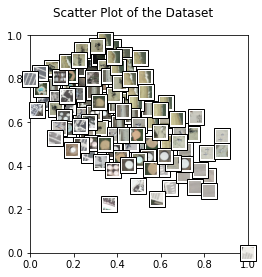

In [5]:
print("Generating scatter plot with thumbnails")
# get a scatter plot with thumbnail overlays
get_scatter_plot_with_thumbnails()

### Get Nearest Neighbours

In [6]:
def get_image_as_np_array(filename: str):
    """Loads the image with filename and returns it as a numpy array.
    """
    img = Image.open(filename).convert('RGB')
    return np.asarray(img)


def get_image_as_np_array_with_frame(filename: str, w: int = 5):
    """Returns an image as a numpy array with a black frame of width w.
    """
    img = get_image_as_np_array(filename)
    ny, nx, _ = img.shape
    # create an empty image with padding for the frame
    framed_img = np.zeros((w + ny + w, w + nx + w, 3))
    framed_img = framed_img.astype(np.uint8)
    # put the original image in the middle of the new one
    framed_img[w:-w, w:-w] = img
    return framed_img


def plot_nearest_neighbors_3x3(example_image: str, i: int, file_name: str):
    """Plots the example image and its eight nearest neighbors.

    """
    n_subplots = 9
    # initialize empty figure
    fig = plt.figure()
    fig.suptitle(f"Nearest Neighbor Plot {i + 1}")
    #
    example_idx = filenames.index(example_image)
    # get distances to the cluster center
    distances = embeddings - embeddings[example_idx]
    distances = np.power(distances, 2).sum(-1).squeeze()
    # sort indices by distance to the center
    nearest_neighbors = np.argsort(distances)[:n_subplots]
    # show images
    for plot_offset, plot_idx in enumerate(nearest_neighbors):
        ax = fig.add_subplot(3, 3, plot_offset + 1)
        # get the corresponding filename
        fname = os.path.join(path_to_data, filenames[plot_idx])
        if plot_offset == 0:
            ax.set_title(f"Example Image")
            plt.imshow(get_image_as_np_array_with_frame(fname))
        else:
            plt.imshow(get_image_as_np_array(fname))
        # let's disable the axis
        plt.axis("off")
    #fig.savefig(file_name)


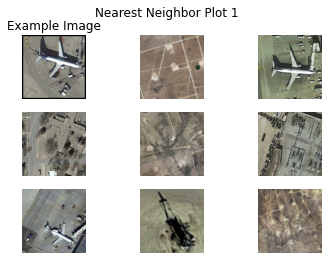

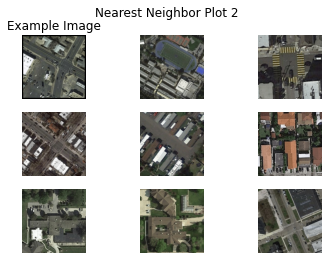

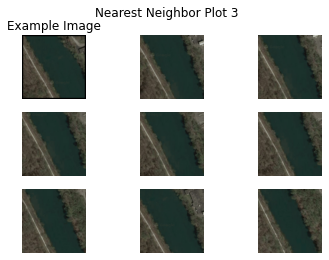

In [7]:
example_images = [
    'airplane007.jpg',
    'intersection193.jpg',
    'river039.jpg',
]

# show example images for each cluster
for i, example_image in enumerate(example_images):
    plot_nearest_neighbors_3x3(example_image, i,'output/'+str(i)+'nn.png')